计算给定数据集的香农熵

In [4]:
from math import log


def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    # 为所有可能的分类 创建字典
    labelCounts = {}
    for featVec in dataSet:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        # 以2为底求对数
        shannonEnt -= prob*log(prob,2)
    return shannonEnt

In [5]:
def createDataSet():
    dataSet = [
        [1, 1, 'yes'],
        [1, 1, 'yes'],
        [1, 0, 'no'],
        [0, 1, 'no'],
        [0, 1, 'no'],
    ]
    labels = ['no surfacing', 'flippers']
    return dataSet, labels

In [6]:
myDat, labels = createDataSet()

In [7]:
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [8]:
calcShannonEnt(myDat)

0.9709505944546686

熵越高，则混合的数据也越多，我们可以在数据集中添加更多的分类，观察熵是如何变化的。
这里我们增加第三个名为maybe的分类，测试熵的变化：

In [9]:
myDat[0][-1] = 'maybe'

In [10]:
myDat

[[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [11]:
calcShannonEnt(myDat)

1.3709505944546687

按照给定特征划分数据集

In [12]:
def splitDataSet(dataSet, axis, value):
    """输入：待划分的数据集、划分数据集的特征、需要返回的特征的值"""
    # 满足分类特征对应value的子集
    retDataSet = []
    for featVec in dataSet:
        # 每个样本的对应属性如果有指定的值，则将该属性剔除，保留其他属性，生成该特征对应值的【子集】
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
        
    return retDataSet

In [13]:
a = [1, 2, 3]
b = [4, 5, 6]

In [14]:
a.append(b)

In [15]:
a

[1, 2, 3, [4, 5, 6]]

In [16]:
a = [1, 2, 3]
a.extend(b)

In [17]:
a

[1, 2, 3, 4, 5, 6]

In [18]:
myDat, labels = createDataSet()

In [19]:
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [20]:
splitDataSet(myDat, 0, 1)

[[1, 'yes'], [1, 'yes'], [0, 'no']]

In [21]:
splitDataSet(myDat, 0, 0)

[[1, 'no'], [1, 'no']]

选择最好的数据集划分方式

In [22]:
def choosebestfeaturetosplit(dataset):   
    """就算出信息增益之后选取信息增益值最高的特征作为下一次分类的标准"""
    numfeatures=len(dataset[0])-1     #计算特征数量，列表【0】表示列的数量，-1是减去最后的类别特征label
    baseentropy=calcShannonEnt(dataset)   #计算数据集的信息熵
    bestinfogain=0.0;bestfeature=-1
    
    # 遍历特征的index
    for i in range(numfeatures):  
        # 求该特征一共有多少个取值
        featlist=[example[i] for example in dataset]
        uniquevals=set(featlist)   #确定某一特征下所有可能的取值
        newentropy=0.0
        
        # 遍历每一个对应特征的取值
        for value in uniquevals:
            subdataset=splitDataSet(dataset,i,value)#抽取在该特征的每个取值下其他特征的值组成新的子数据集
            prob=len(subdataset)/float(len(dataset))#计算该特征下的每一个取值对应的概率（或者说所占的比重）
            #计算该特征下每一个取值的子数据集的信息熵，即特征a中，a1占a1...an所有值的占比*信息熵，再求和
            newentropy +=prob*calcShannonEnt(subdataset)
            
        #计算每个特征的信息增益
        infogain=baseentropy-newentropy
        #  print("第%d个特征是的取值是%s，对应的信息增益值是%f"%((i+1),uniquevals,infogain))
        if(infogain>bestinfogain):
            bestinfogain=infogain
            bestfeature=i
    # print("第%d个特征的信息增益最大，所以选择它作为划分的依据，其特征的取值为%s,对应的信息增益值是%f"%((i+1),uniquevals,infogain))
    return bestfeature

In [23]:
myDat, labels = createDataSet()

In [24]:
choosebestfeaturetosplit(myDat)

0

该函数使用分类名称的列表，
然后创建键值为classList中唯一值的数据字典，字典对象存储了classList中每个类标签出
现的频率，最后利用operator操作键值排序字典，并返回出现次数最多的分类名称

In [25]:
import operator


def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys(): classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

创建树的函数代码

In [26]:
def createTree(dataSet, labels):
    # 类别完全相同则停止继续划分
    # 获取所有的label
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    
    # 遍历完所有特征时返回出现次数最多的
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)
    
    bestFeat = choosebestfeaturetosplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    
    # 得到列表包含的所有属性值
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    
    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatLabel][value]= createTree(splitDataSet(dataSet, bestFeat, value), subLabels)
        
    return myTree

In [27]:
myDat, labels = createDataSet()

In [29]:
myTree = createTree(myDat, labels)

In [30]:
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

- 使用文本注解绘制树节点

In [44]:
import matplotlib.pyplot as plt

plt.rcParams['font.family']='SimHei'


decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction',
                            xytext=centerPt, 
                            textcoords='axes fraction', 
                            va="center", ha="center", 
                            bbox=nodeType, 
                            arrowprops=arrow_args
                           )
    
def createPlot():
    fig = plt.figure(1, facecolor='white')
    # 清空绘图区
    fig.clf()
    createPlot.ax1 = plt.subplot(111, frameon=False)
    plotNode(u'决策节点', (0.5, 0.1), (0.1, 0.5), decisionNode)
    plotNode(u'叶节点', (0.8, 0.1), (0.3, 0.8), leafNode)
    plt.show()

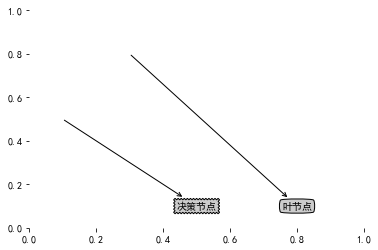

In [45]:
createPlot()

In [18]:
def getNumLeafs(myTree):
    """获取叶节点的数目"""
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs

In [20]:
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

In [7]:
def retrieveTree(i):
    listOfTrees = [
        {'no sufacing': {0: 'no', 1: {'filppers': {0: 'no', 1: 'yes'}}}},
        {'no sufacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}},        }
    ]
    return listOfTrees[i]

In [8]:
retrieveTree(1)

{'no sufacing': {0: 'no',
  1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}

In [13]:
myTree = retrieveTree(0)
myTree

{'no sufacing': {0: 'no', 1: {'filppers': {0: 'no', 1: 'yes'}}}}

In [19]:
getNumLeafs(myTree)

3

In [21]:
getTreeDepth(myTree)

2

In [22]:
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString)

In [ ]:
def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    firstStr = myTree.keys()[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__  == 'dict':
            plotTree(secondDict[key], cntrPt, str[key])
        else:
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW, plotMidText(cntrPt, parentPt, nodeTxt)